# Generating Songs Using an LSTM from Genius Lyrics
Data collection info here ---> https://github.com/johnwmillr/LyricsGenius

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import json
from torch.utils.data.sampler import SubsetRandomSampler
from torch import optim
from LSTM import *

# Check if your system supports CUDA
torch.manual_seed(42069)
np.random.seed(42069)
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [4]:
dataset = loader('Lyrics_TheWeeknd.json', with_tags=True)
batch_size = 1

In [5]:
print(dataset.songs[1])

<start>
Title: Starboy
[Verse 1]
I'm tryna put you in the worst mood, ah
P1 cleaner than your church shoes, ah
Milli point two just to hurt you, ah
All red Lamb’ just to tease you, ah
None of these toys on lease too, ah
Made your whole year in a week too, yah
Main bitch out your league too, ah
Side bitch out of your league too, ah

[Pre-Chorus]
House so empty, need a centerpiece
20 racks a table cut from ebony
Cut that ivory into skinny pieces
Then she clean it with her face man I love my baby
You talking money, need a hearing aid
You talking bout me, I don't see the shade
Switch up my style, I take any lane
I switch up my cup, I kill any pain

[Chorus]
Look what you've done
I’m a motherfuckin' starboy
Look what you've done
I'm a motherfuckin' starboy

[Verse 2]
Every day a nigga try to test me, ah
Every day a nigga try to end me, ah
Pull off in that Roadster SV, ah
Pockets overweight, gettin' hefty, ah
Coming for the king, that's a far cry, ah
I come alive in the fall time, I
No compe

# Train Validation Splits

In [6]:
validation_split = .3
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(42069)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

# LSTM Architecture

In [9]:
input_dim = len(dataset.char_dict)
hidden_dim = 200
n_layers = 4
batch_size = 1

model = Nnet(input_dim, hidden_dim, n_layers, dropout=0.25)
model.to(device)

Nnet(
  (lstm_layer): LSTM(109, 200, num_layers=4, dropout=0.25)
  (fc): Linear(in_features=200, out_features=109, bias=True)
)

# Loss Functions and Optimizer

In [19]:
#loss criteria are defined in the torch.nn package
criterion = nn.CrossEntropyLoss()

#Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Training Process

In [8]:
epochs = 200
clip = 10
chunk_len = 500
early_stop = True
early_stop_thresh = 15
valid_loss_min = np.Inf

val_losses_epoch = []
train_losses_epoch = []

def get_labels(inputs):
    labels = torch.zeros(inputs.shape[0])

    for i,oneHot in enumerate(inputs[1:]):
        idx = oneHot.argmax().item()
        labels[i] = idx
        
    return labels


index_to_char = {v: k for k, v in dataset.char_dict.items()}

model.train()
print("Training...")
for epoch in range(epochs):
    # training process
    for sample_idx, song in enumerate(train_loader):
        h = model.init_hidden(batch_size)
        song_chunks = chunkstring(song[0], chunk_len)
        for chunk in song_chunks:
            inputs = encode_chunk(chunk, dataset.char_dict)
            labels = get_labels(inputs)
            h = tuple([e.data for e in h])
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            model.zero_grad()
            output, h = model(inputs, h)
            loss = criterion(output, labels)
            h = tuple([e.detach() for e in h])
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
        
        
    # validation process
    val_losses = []
    model.eval()
    #print("Evaluating on validation set...")
    for sample_idx, song in enumerate(val_loader):
#         if sample_idx % 100 == 0:
#             print("Evaluating on song %d (%d/%d)"  % (sample_idx, sample_idx, len(val_loader)))
        val_h = model.init_hidden(batch_size)
        val_h = tuple([each.data for each in val_h])
        song_chunks = chunkstring(song[0], chunk_len)
        
        for chunk in song_chunks:
            inputs = encode_chunk(chunk, dataset.char_dict)
            labels = get_labels(inputs)
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, labels)
            val_losses.append(val_loss.item())
        
    # evaluate on the training set to get training loss metrics
    train_losses = []
    #print("Evaluting on training set...")
    for sample_idx, song in enumerate(train_loader):
        h = model.init_hidden(batch_size)
        song_chunks = chunkstring(song[0], chunk_len)
        for chunk in song_chunks:
            inputs = encode_chunk(chunk, dataset.char_dict)
            labels = get_labels(inputs)
            h = tuple([e.data for e in h])
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            output, h = model(inputs, h)
            train_loss = criterion(output, labels)
            train_losses.append(train_loss.item())
    
    
    train_losses_epoch.append(np.mean(train_losses))
    val_losses_epoch.append(np.mean(val_losses))

    model.train()
    print("Epoch: {}/{}...".format(epoch+1, epochs),
          "Training Loss: {:.6f}...".format(np.mean(train_losses)),
          "Validation Loss: {:.6f}".format(np.mean(val_losses)))
    
    if epoch % 5 == 0:
        print('Creating training checkpoint...')
        # save training progress every five epochs
        state = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, 'weeknd_state_ckpt.pth')
    
    if val_losses_epoch[epoch] <= valid_loss_min:
        torch.save(model.state_dict(), './weeknd_state_dict.pth')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
        valid_loss_min = np.mean(val_losses)
        
        if early_stop:
            early_stop_strikes = 0
    
    else:
        if early_stop:
            early_stop_strikes += 1
            if early_stop_strikes >= early_stop_thresh:
                print("Early stopping is enabled. Training will now stop.")
                break
            else:
                print("Early stopping is enabled. Training will stop in %d epochs if validation loss does not go down."
                    % (early_stop_thresh-early_stop_strikes))

NameError: name 'model' is not defined

# Loss Curves

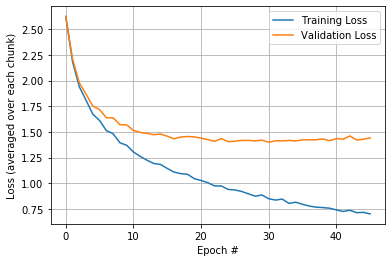

In [24]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(train_losses_epoch)
plt.plot(val_losses_epoch)
plt.grid()
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch #')
plt.ylabel('Loss (averaged over each chunk)')
plt.show()

# Generating Lyrics

In [10]:
from torch.nn.functional import softmax
from torch.distributions.categorical import Categorical
from copy import deepcopy


model = Nnet(input_dim, hidden_dim, n_layers, dropout=0.25)
model.load_state_dict(torch.load('weeknd_state_dict.pth'))
model.to(device)
model.eval()


def get_next_char(model, char_dict, hidden, input_token='<start>', sampling_scheme='softmax', temperature=0.7):
    '''Gets the next character given a chunk input_token
    :param: a pytorch neural network to be passed
    :char_dict: a dictionary mapping alphanumeric characters of type str to integers
    :input_token: the string to begin on for the LSTM
    '''
    inputs = encode_chunk(input_token, char_dict)
    h = tuple([e.data for e in hidden])
    inputs = inputs.to(device)

    output, h = model(inputs, h)

    if sampling_scheme == 'softmax':
        prediction_vector = softmax(output / temperature, dim=1)
        output_dist = Categorical(probs=prediction_vector)
        next_char = output_dist.sample()[-1]
    else:
        # argmax sampling scheme
        prediction_vector = softmax(output, dim=1)
        next_char = prediction_vector.argmax(dim=1)[-1]
    
    return next_char, h

In [11]:
generated_file_size = 10000 # characters
model_name = 'Weeknd_LSTM'

next_chunk = '<start>\nTitle:'

out = deepcopy(next_chunk)
    
index_to_char = {v: k for k, v in dataset.char_dict.items()}

max_chunk_size = 100
#try passing in the token with 0'd hidden units at the beginning then take the hidden unit output
#from that and pass that back in with the token again and go on from there
hidden = model.init_hidden(1)
for progress,i in enumerate(range(generated_file_size)):
    if progress % 500 == 0:
        print("Generation progress: %d/%d characters" % (progress, generated_file_size))
    if progress == 0 or next_chunk[-len('<end>'):] == '<end>':
        if progress > 0:
            next_chunk = '<start>\n'
            out += '\n<start>\n'
        #hidden = model.init_hidden(1)
    
    (next_char, h) = get_next_char(model, dataset.char_dict, hidden, input_token=next_chunk)
    char = index_to_char[next_char.item()]
    
    if len(next_chunk) < max_chunk_size:
        next_chunk += char
    else:
        next_chunk = next_chunk[1:] + char
    out += char
    
with open("generated_songs/generated_songs_" + model_name + ".txt", "w") as text_file:
    print(out, file=text_file)
    
print(out)

Generation progress: 0/10000 characters
Generation progress: 500/10000 characters
Generation progress: 1000/10000 characters
Generation progress: 1500/10000 characters
Generation progress: 2000/10000 characters
Generation progress: 2500/10000 characters
Generation progress: 3000/10000 characters
Generation progress: 3500/10000 characters
Generation progress: 4000/10000 characters
Generation progress: 4500/10000 characters
Generation progress: 5000/10000 characters
Generation progress: 5500/10000 characters
Generation progress: 6000/10000 characters
Generation progress: 6500/10000 characters
Generation progress: 7000/10000 characters
Generation progress: 7500/10000 characters
Generation progress: 8000/10000 characters
Generation progress: 8500/10000 characters
Generation progress: 9000/10000 characters
Generation progress: 9500/10000 characters
<start>
Title: Not In The Fame
[Verse 1]
We conce the wave, no
No word, when I like your face
Said she make me call for love
You're leave it all